In [1]:
#Import necessary packages
import math
import numpy as np
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
import pandas as pd
from scipy.optimize import brute, fmin, minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

#Install import_ipynb so we can read dependenies as jupyter notebooks
!pip install ipynb

#Import jupyer notebook depdendencies 
from ipynb.fs.full.FFT_option_valuation import BSM_call_value_FFT
from ipynb.fs.full.Vasicek_calibration import Vasicek_calibration , r_list #########CHANGED TO Vasicek_calibration
from ipynb.fs.full.Vasicek_zcb_valuation import zcb_price  ############CHANGED TO Vasicek_zcb_valuation, zcb_price

In [2]:
#Import CSV file with option data as a panda dataframe
raw = pd.read_csv('C:/Users/1/Downloads/A_Python_in_financial_engineering/Project/option_data.csv')

#Convert variables Maturity and Date to pandas datetime objects
raw['Maturity']= pd.to_datetime(raw['Maturity'], format='%Y-%m-%d') 
raw['Date']= pd.to_datetime(raw['Date'], format='%Y-%m-%d')

In [3]:
#Create a copy so we do not have to reload the data set if we start over
data = raw.copy()
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Maturity  154 non-null    datetime64[ns]
 1   Strike    154 non-null    float64       
 2   Call      154 non-null    float64       
 3   Date      154 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 4.9 KB


,Maturity,Strike,Call,Date
0,2020-12-30,85.0,13.25,2020-12-28
1,2020-12-30,87.5,11.00,2020-12-28
2,2020-12-30,90.0,8.30,2020-12-28
3,2020-12-30,92.5,5.80,2020-12-28
4,2020-12-30,95.0,3.50,2020-12-28
...,...,...,...,...
149,2022-12-16,120.0,7.30,2020-12-28
150,2022-12-16,130.0,5.25,2020-12-28
151,2022-12-16,140.0,3.65,2020-12-28
152,2022-12-16,150.0,2.40,2020-12-28


In [4]:
#Create a variable, T, that shows how much, as a fraction of a year, that is left until maturity
data['diff'] = data['Maturity'] - data['Date']                     #number of days left to maturity
data['T']=(data['diff'].astype('timedelta64[D]').astype(int))/365  

#Drop unnecessary varibles
data.drop(['diff'], axis = 1, inplace=True)                         ############THIS CELL IS PARTLY CHANGED

#Drop max.rows option so we can see full dataframe to decide where implied vol gives NaN values
pd.set_option('display.max_rows', None)                                          
data

,Maturity,Strike,Call,Date,T
0,2020-12-30,85.0,13.250,2020-12-28,0.005479
1,2020-12-30,87.5,11.000,2020-12-28,0.005479
2,2020-12-30,90.0,8.300,2020-12-28,0.005479
3,2020-12-30,92.5,5.800,2020-12-28,0.005479
4,2020-12-30,95.0,3.500,2020-12-28,0.005479
5,2020-12-30,97.5,1.350,2020-12-28,0.005479
6,2020-12-30,100.0,0.405,2020-12-28,0.005479
7,2021-01-08,85.0,13.500,2020-12-28,0.030137
8,2021-01-08,87.5,11.000,2020-12-28,0.030137
9,2021-01-08,90.0,8.500,2020-12-28,0.030137


In [5]:
#Reset maximum number of rows displayed to 10 rows                              ###########THIS  WHOLE CELL IS NEW
pd.set_option('display.max_rows', 10)

#Keep only options with less than 1 year to maturity
data = data[data['T'] <= 1]

#Keep only options with at least one week to maturity
data = data[data['T'] >= 7/365]
options = data
options

,Maturity,Strike,Call,Date,T
7,2021-01-08,85.0,13.500,2020-12-28,0.030137
8,2021-01-08,87.5,11.000,2020-12-28,0.030137
9,2021-01-08,90.0,8.500,2020-12-28,0.030137
10,2021-01-08,92.5,6.000,2020-12-28,0.030137
11,2021-01-08,95.0,3.900,2020-12-28,0.030137
...,...,...,...,...,...
132,2021-12-17,120.0,4.125,2020-12-28,0.969863
133,2021-12-17,130.0,2.425,2020-12-28,0.969863
134,2021-12-17,140.0,1.375,2020-12-28,0.969863
135,2021-12-17,150.0,0.825,2020-12-28,0.969863


In [6]:
#Initial short rate (Stibor 28.12.2020)
r0 = r_list[0]  

#Calibrate Short Rate Model to get calibrated estimates of CIR parameters used for zcb valuation
kappa_r, theta_r, sigma_r = Vasicek_calibration()                         #########CHANGED TO Vasicek_calibration()

r = []
for row, option in options.iterrows():
    B0T = zcb_price([kappa_r, theta_r, sigma_r, r0, option['T']])                    ##########CHANGED TO zcb_price
    r.append(-math.log(B0T) / option['T'])
options['r'] = r
options

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 153
         Function evaluations: 288


,Maturity,Strike,Call,Date,T,r
7,2021-01-08,85.0,13.500,2020-12-28,0.030137,-0.000491
8,2021-01-08,87.5,11.000,2020-12-28,0.030137,-0.000491
9,2021-01-08,90.0,8.500,2020-12-28,0.030137,-0.000491
10,2021-01-08,92.5,6.000,2020-12-28,0.030137,-0.000491
11,2021-01-08,95.0,3.900,2020-12-28,0.030137,-0.000491
...,...,...,...,...,...,...
132,2021-12-17,120.0,4.125,2020-12-28,0.969863,0.000721
133,2021-12-17,130.0,2.425,2020-12-28,0.969863,0.000721
134,2021-12-17,140.0,1.375,2020-12-28,0.969863,0.000721
135,2021-12-17,150.0,0.825,2020-12-28,0.969863,0.000721


In [7]:
##################################################################################################################
################################################ Preliminaries ###################################################

#Define Stock price (Ericsson B, 28.12.2020)               
S0 = 98.36                                                      ###########S0 HAS OBVIOUSLY CHANGED

#Slice the dataframe
#Default option selects all options in the csv file

##################################################################################################################
############### Solve for B&S implied volatility with stochastic interest rates using Newton-Rhapson #############

def implied(c, S, K, T, r, n):
#Initial guess: https://www.researchgate.net/publication/245065192_
#                       A_Simple_Formula_to_Compute_the_Implied_Standard_Deviation

    initial_guess = np.sqrt(2 * np.pi / T) * c / S
    implied_vol = initial_guess
    for i in range(1, n):
        d1 = (np.log(S / K) + (r + 0.5 * implied_vol**2) * T) / (implied_vol * np.sqrt(T))
        d2 = d1 - implied_vol * np.sqrt(T)
        c0 = S * norm.cdf(d1) - K * np.exp(-r * T)*norm.cdf(d2)
        vega = S * norm.pdf(d1) * np.sqrt(T)
        implied_vol = implied_vol - (c0 - c) / vega
        #Need to include a condition that ensures that implied volatility is positive#########################
    return implied_vol

#Run the function 'implied' with max 10000 iterations using our pandas columns 
options['impVol'] = implied(options['Call'].values, S0, options['Strike'].values, options['T'].values, options['r'].values, 10000) 

##################################################################################################################
######################### Calculation of B&S option values with stochastic interest rates ########################

def BSM_calculate_model_values_FFT():
    ''' Calculates all model prices given implied volatility. '''  
    values = []
    for row, option in options.iterrows():
        model_value = BSM_call_value_FFT(S0, option['Strike'], option['T'], option['r'], option['impVol'])
        values.append(model_value)
    return np.array(values) 

##################################################################################################################
################################################# Run calibration ################################################

if __name__ == '__main__': 
    
    #Create pandas column for BSM call options values based on calibrated data
    options['Model'] = BSM_calculate_model_values_FFT()

<ipython-input-7-cc1889851eeb>:24: RuntimeWarning: divide by zero encountered in true_divide
  implied_vol = implied_vol - (c0 - c) / vega
<ipython-input-7-cc1889851eeb>:24: RuntimeWarning: overflow encountered in true_divide
  implied_vol = implied_vol - (c0 - c) / vega
<ipython-input-7-cc1889851eeb>:20: RuntimeWarning: overflow encountered in square
  d1 = (np.log(S / K) + (r + 0.5 * implied_vol**2) * T) / (implied_vol * np.sqrt(T))
<ipython-input-7-cc1889851eeb>:20: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(S / K) + (r + 0.5 * implied_vol**2) * T) / (implied_vol * np.sqrt(T))
C:\Users\1\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [8]:
#Drop max.rows option so we can see full dataframe 
pd.set_option('display.max_rows', None)

#Drop all rows where NaN exists in the impVol column
options.dropna(subset=['impVol'], how='all', inplace=True)

#Only keep the rows with positive implied volatilities (can be taken care of in the implied vol calc. instead)
options = options[options['impVol'] >= 0]
options

,Maturity,Strike,Call,Date,T,r,impVol,Model
7,2021-01-08,85.0,13.500,2020-12-28,0.030137,-0.000491,0.493110,13.500000
8,2021-01-08,87.5,11.000,2020-12-28,0.030137,-0.000491,0.411773,11.000000
9,2021-01-08,90.0,8.500,2020-12-28,0.030137,-0.000491,0.330325,8.500000
10,2021-01-08,92.5,6.000,2020-12-28,0.030137,-0.000491,0.247730,6.000000
11,2021-01-08,95.0,3.900,2020-12-28,0.030137,-0.000491,0.257672,3.900000
12,2021-01-08,97.5,2.150,2020-12-28,0.030137,-0.000491,0.248615,2.150000
13,2021-01-08,100.0,0.900,2020-12-28,0.030137,-0.000491,0.231144,0.900000
16,2021-01-15,82.5,16.000,2020-12-28,0.049315,-0.000437,0.449795,16.000000
17,2021-01-15,85.0,13.500,2020-12-28,0.049315,-0.000437,0.385770,13.500000
18,2021-01-15,87.5,11.000,2020-12-28,0.049315,-0.000437,0.322157,11.000000


In [9]:
#Create a variable, T, that shows how much, as a fraction of a year, that is left until maturity
options['diff'] = options['Maturity'] - options['Date']     #number of days left to maturity

#Create a new variable equal to 'diff' but in the integer format not the timedelta64 format
options['Days'] = options['diff'].astype('timedelta64[D]').astype(int)

#Createa a vector of unique maturities
maturities = options.Days.unique()
maturities 

array([11.000, 18.000, 25.000, 53.000, 81.000, 172.000, 263.000, 354.000])

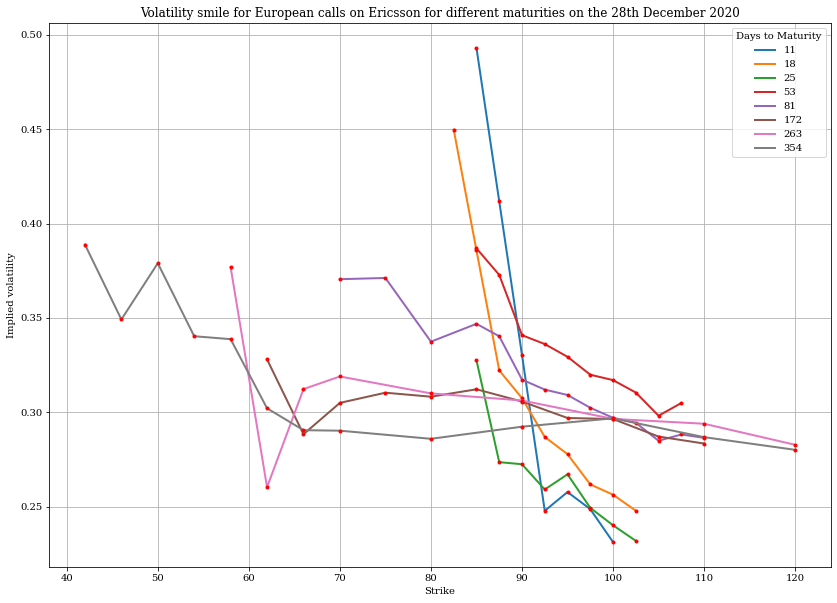

In [10]:
#Plot the implied volatilties in a line plot
plt.figure(figsize=(14, 10))                           #set size of figure
for maturity in maturities:                            #maturities is a list created earlier
    iv_plot = options[options.Days == maturity] #defines maturity as the unique numbers in the Days column of the data set
    #Select x and y values for plot for each maturity
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], label=maturity, lw=2)
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], 'r.', label='')
plt.grid(True) 
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('Volatility smile for European calls on Ericsson for different maturities on the 28th December 2020')
plt.legend(title="Days to Maturity")

In [11]:
#Drop all rows which which have call options that are very deep out of the money (Strike < 66)
options = options[options['Strike'] >= 66 ]

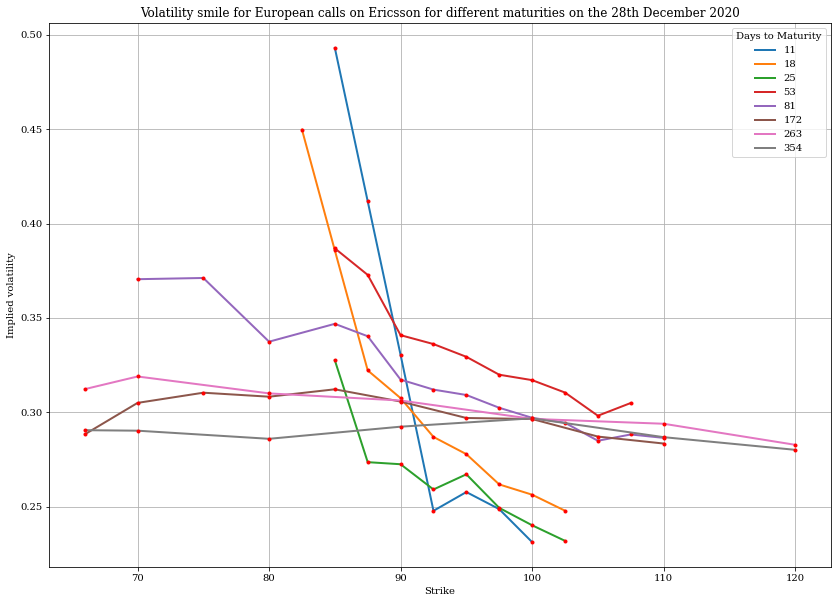

In [12]:
#Plot the implied volatilties in a line plot
plt.figure(figsize=(14, 10))                           #set size of figure
for maturity in maturities:                            #maturities is a list created earlier
    iv_plot = options[options.Days == maturity] #defines maturity as the unique numbers in the Days column of the data set
    #Select x and y values for plot for each maturity
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], label=maturity, lw=2)
    plt.plot(iv_plot['Strike'], iv_plot['impVol'], 'r.', label='')
plt.grid(True) 
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.title('Volatility smile for European calls on Ericsson for different maturities on the 28th December 2020')
plt.legend(title="Days to Maturity")